In [1]:
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [165]:
cs["8a"] = Load.case_1D(rf"C:\Users\mikek\OneDrive\Project\collab\tech\cases\step1d\sta8a-6d_mass_x1.25")

c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [2]:
db = CaseDB()

toload = {
    "vis4" : "sta11d-ar4pc",
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d\{toload[name]}"))


Loading sta11d-ar4pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [13]:
write_file(cs, "a2.pkl")

a2.pkl written


In [9]:
cs = read_file("a2.pkl")

a2.pkl loaded


In [5]:
%matplotlib widget

In [6]:
caselabels = {

    "base0" : "0% Argon",
    "base1" : "1% Argon",
    "base2" : "2% Argon",
    "base4" : "4% Argon",
    "vis0" : "0% Argon, ion_viscosity",
    "vis1" : "0% Argon, ion_viscosity",
    "vis2" : "0% Argon, ion_viscosity",
    "vis4" : "0% Argon, ion_viscosity",
}

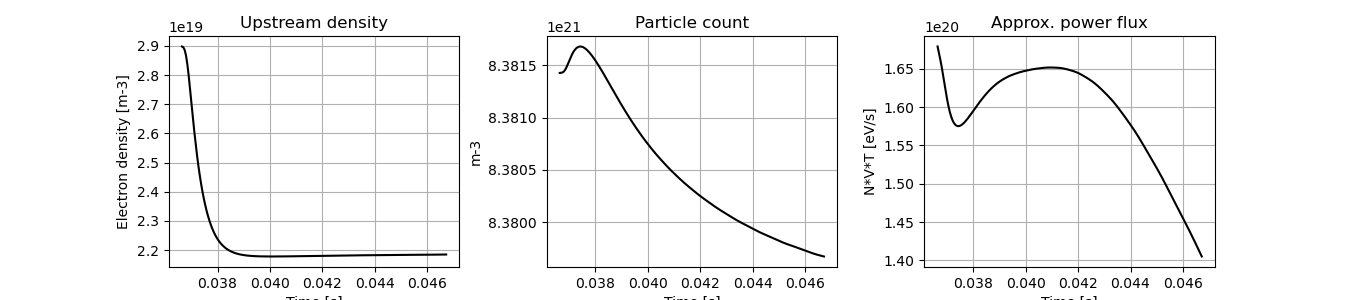

In [8]:

ds = cs["vis4"].ds.isel(pos=slice(2,-1), t = slice(2,None))

particle_count = ((ds["Ne"] + ds["Nd"])*ds["dv"]).sum("pos")
nu = ds["Ne"].isel(pos=0)

fig, axes = plt.subplots(1,3, figsize=(4.5*3, 3))
fig.subplots_adjust(wspace=0.3)
nu.plot(ax = axes[0], c = "k")
# (particle_count/particle_count.isel(t=0)).plot(ax = axes[1], c = "k")
particle_count.plot(ax = axes[1], c = "k")
pflux = (ds["Vd+"] * ds["Nd+"] * ds["Td+"]).isel(pos=-1).plot(ax = axes[2], c = "k")

# pflux.plot(ax=axes[2])

axes[0].set_title("Upstream density")
# axes[1].set_title("Fractional particle count")
axes[1].set_title("Particle count")
axes[2].set_title("Approx. power flux")
axes[2].set_ylabel("N*V*T [eV/s]")
axes[1].set_ylabel("m-3")
# axes[2].set_yscale("log")

for ax in axes:
    ax.grid()


NameError: name 'caselabels' is not defined

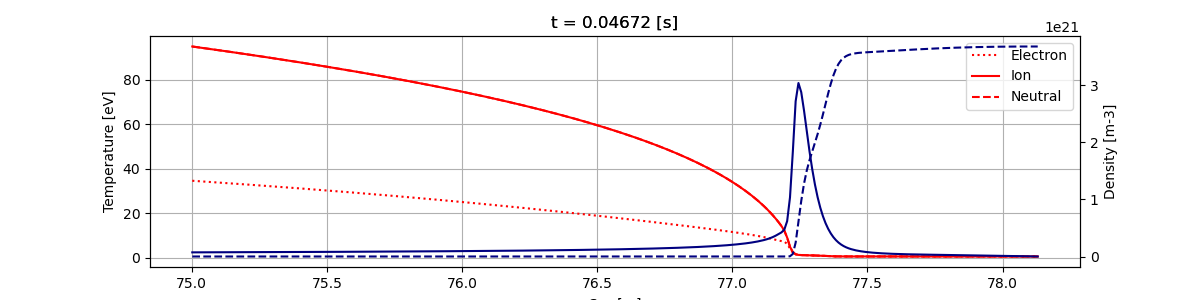

In [10]:
casename = "vis4"
ds = cs[casename].ds.isel(pos=slice(1,-1), t = -1)
ds = ds.sel(pos=slice(75,None))

fig, ax = plt.subplots(dpi = 100, figsize = (12,3))
ds["Te"].plot(ax = ax, c = "r", ls = ":", label = "Electron")
ds["Td+"].plot(ax = ax, c = "r", ls = "-", label = "Ion")
ds["Td+"].plot(ax = ax, c = "r", ls = "--", label = "Neutral")

ax2 = ax.twinx()
ds["Ne"].plot(ax = ax2, c = "navy", ls = "-")
ds["Nd"].plot(ax = ax2, c = "navy", ls = "--")

# ax.set_xscale("log")
ax.set_xlabel("$S_{par}$ [m]")
ax.set_ylabel("Temperature [eV]")
ax2.set_ylabel("Density [m-3]")
ax.grid()
ax.legend()
ax.set_title(caselabels[casename])
ax2.set_title("")


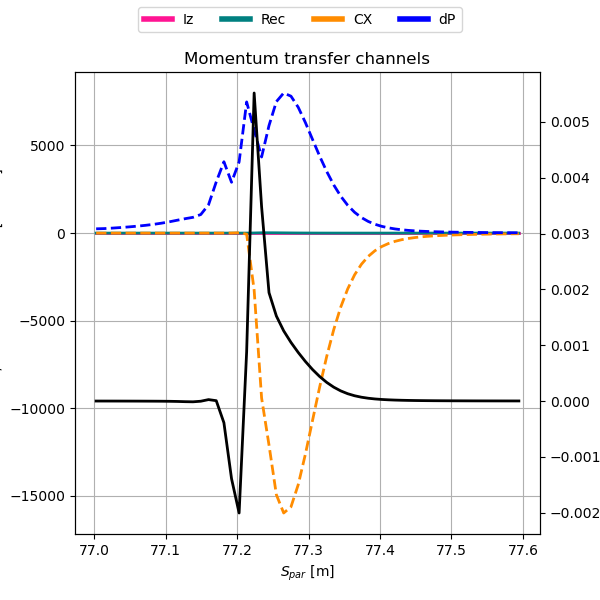

In [14]:
from matplotlib.lines import Line2D
import xarray as xr
fig, ax = plt.subplots(dpi = 100, figsize = (6,6))
ax.grid()
ax2 = ax.twinx()
ms = 0
lw = 2

gradp = ds["Pd+"].differentiate("pos") * -1
ds = cs[casename].ds.isel(pos=slice(1,-1), t = -1)
ds = ds.sel(pos=slice(75,None))

for name in ["vis4"]:

    ds = cs[name].ds.isel(t=-1, pos = slice(2,-2))
    ds = ds.sel(pos=slice(77, 77.6))
    pos = ds["pos"]

    # ax.plot(pos, ds["Rar"])
    ax.plot(pos, ds["Fd+_iz"], marker = "o", ms = ms, lw = lw, c = "deeppink")
    ax.plot(pos, abs(ds["Fd+_rec"]), marker = "o", ms = ms, lw = lw, c = "teal")
    ax.plot(pos, ds["Fdd+_cx"]*-1, marker = "o", ms = ms, lw = lw, c = "darkorange", ls = "--")
    ax.plot(pos, gradp, marker = "o", ms = ms, lw = lw, c = "blue", ls = "--")
    ax2.plot(pos, ds["NVd+"], marker = "o", ms = ms, lw = 2, c = "black")
    
ax.set_xlabel("$S_{par}$ [m]")
ax.set_ylabel("Ionisation/recombination rate [m-3s-1]")
ax2.set_ylabel("CX Momentum transfer source [kg/m3/s2]")

custom_lines = [Line2D([0], [0], color="deeppink", lw=4, label = "Iz mom"),
                Line2D([0], [0], color="teal", lw=4, label = "Rec mom"),
                Line2D([0], [0], color="darkorange", lw=4, label = "CX mom"),
                Line2D([0], [0], color="blue", lw=4, label = "dP/dx"),
                Line2D([0], [0], color="black", lw=4, label = "Momentum"),
                ]

ax.set_title("Momentum transfer channels")
fig.legend(custom_lines, ["Iz", "Rec", "CX", "dP"],
           loc = "upper center", ncol = 4)
# ax.plot(pos, abs(ds["Fdd+_cx"]), marker = "o", ms = 3)

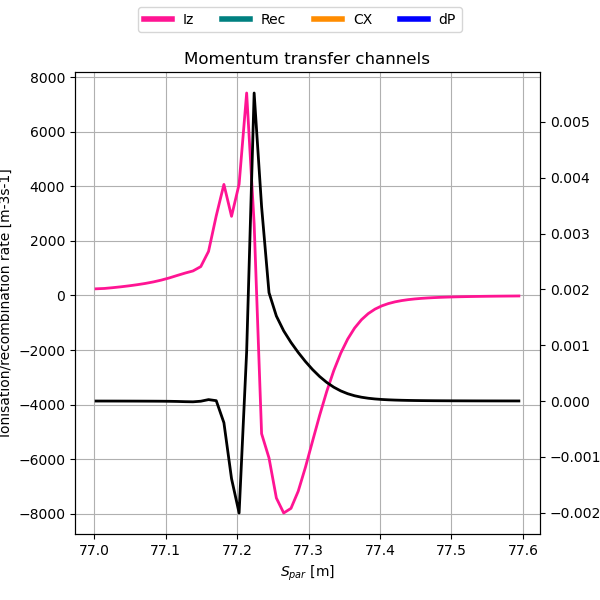

In [16]:
from matplotlib.lines import Line2D
import xarray as xr
fig, ax = plt.subplots(dpi = 100, figsize = (6,6))
ax.grid()
ax2 = ax.twinx()
ms = 0
lw = 2

gradp = ds["Pd+"].differentiate("pos")
net_F = -gradp - ds["Fdd+_cx"]

for name in ["vis4"]:

    ds = cs[name].ds.isel(t=-1, pos = slice(2,-2))
    ds = ds.sel(pos=slice(77, 77.6))
    pos = ds["pos"]

    # ax.plot(pos, ds["Rar"])
    ax.plot(pos, net_F, marker = "o", ms = ms, lw = lw, c = "deeppink")
    # ax.plot(pos, ds["SNVd+"], marker = "o", ms = ms, lw = lw, c = "deeppink")
    # ax.plot(pos, abs(ds["Fd+_rec"]), marker = "o", ms = ms, lw = lw, c = "teal")
    # ax.plot(pos, abs(ds["Fdd+_cx"]), marker = "o", ms = ms, lw = lw, c = "darkorange", ls = "--")
    # ax.plot(pos, gradp, marker = "o", ms = ms, lw = lw, c = "blue", ls = "--")
    ax2.plot(pos, ds["NVd+"], marker = "o", ms = ms, lw = 2, c = "black")
    
ax.set_xlabel("$S_{par}$ [m]")
ax.set_ylabel("Ionisation/recombination rate [m-3s-1]")
ax2.set_ylabel("CX Momentum transfer source [kg/m3/s2]")

custom_lines = [Line2D([0], [0], color="deeppink", lw=4, label = "Iz mom"),
                Line2D([0], [0], color="teal", lw=4, label = "Rec mom"),
                Line2D([0], [0], color="darkorange", lw=4, label = "CX mom"),
                Line2D([0], [0], color="blue", lw=4, label = "dP/dx"),
                Line2D([0], [0], color="black", lw=4, label = "Momentum"),
                ]

ax.set_title("Momentum transfer channels")
fig.legend(custom_lines, ["Iz", "Rec", "CX", "dP"],
           loc = "upper center", ncol = 4)
# ax.plot(pos, abs(ds["Fdd+_cx"]), marker = "o", ms = 3)

In [4]:
%matplotlib widget

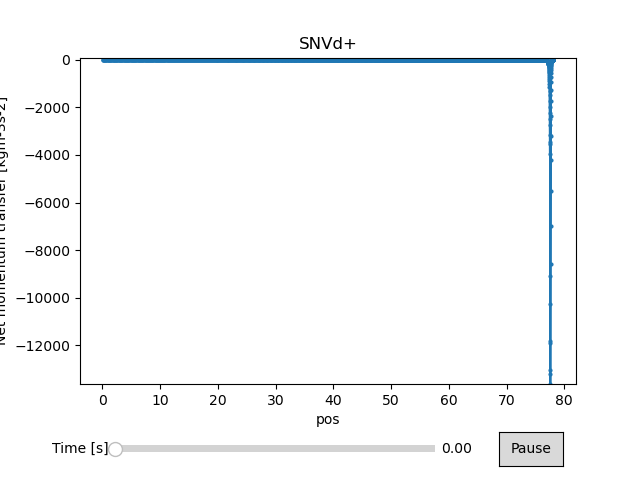

In [6]:
casename = "vis4"

xbout.plotting.animate.animate_line(cs[casename].ds.isel(pos=slice(2,-2))["SNVd+"], marker = "o", ms = 2)

ValueError: not enough values to unpack (expected 2, got 1)

In [115]:
%matplotlib inline

Text(0.5, 29.71666626930236, '$S_{par}$ [m]')

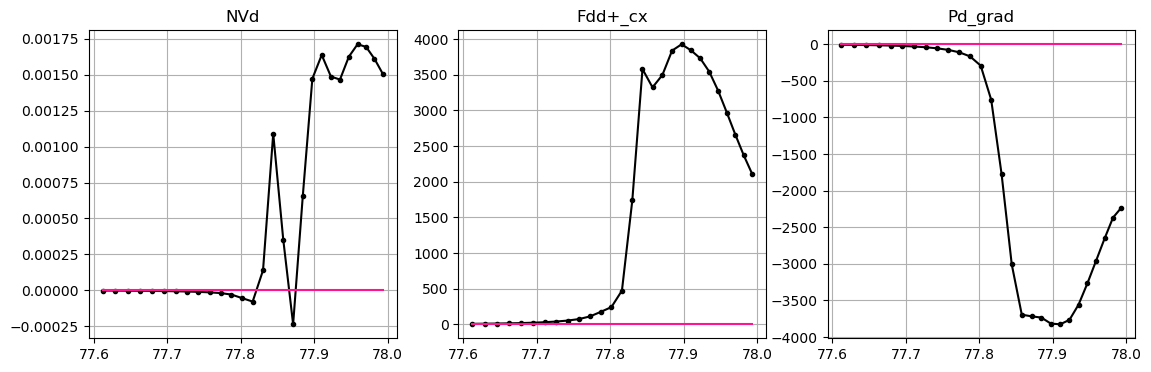

In [192]:
from matplotlib.lines import Line2D

ms = 0
lw = 2

# ds = cs["base4"].ds.isel(t=-1, pos = slice(2,-2)); ds = ds.sel(pos=slice(77, 77.5))
ds = cs["8a"].ds.isel(t=-1, pos = slice(2,-2)); ds = ds.sel(pos=slice(77.6, 78))

ds["Sd+"] = ds["Sd+_iz"] + ds["Sd+_rec"]
ds["Fd+"] = ds["Fd+_iz"] + ds["Fd+_rec"] + ds["Fdd+_cx"]
ds["R"] = ds["Rd+_ex"] + ds["Rd+_rec"] + ds["Rar"]
ds["Pd+_grad"] = ds["Pd+"].differentiate("pos") *-1
ds["Pd_grad"] = ds["Pd"].differentiate("pos") *-1
# ds["Fdd+_cx"] *= -1


pos = ds["pos"]

# params = ["Sd+", "Fd+_iz", "" "NVd+", "Vd+", "Pd+"]
# params = ["Fd+", "Fd+_iz", "Fd+_rec", "Fdd+_cx"]
# params = ["NVd+", "Fd+",  "Fd+_iz", "Fd+_rec", "Fdd+_cx"]
# params = ["NVd+", "Sd+", "Sd+_iz", "Sd+_rec"]
# params = ["NVd+", "Fd+", "Pd+_grad", "R"]
# params = ["Sd_src", "Sd+_src"]

# params = ["NVd+", "Fdd+_cx", "Pd+_grad"]
params = ["NVd", "Fdd+_cx", "Pd_grad"]
# params = ["NVd+", "NVd", "Fdd+_cx", "Pd+_grad", "Pd_grad"]

num_plots = len(params)
fig, axes = plt.subplots(1, num_plots, dpi = 100, figsize = (4.5*num_plots,4))

colors = ["teal", "darkorange"]
labels = ["Neutrals", "Ions"]

for i, param in enumerate(params):
    axes[i].plot(pos, ds[param], c="k", marker = "o", ms = 3, label = labels[j])        
    axes[i].plot(pos, np.zeros_like(ds[param]), c = "deeppink")
    axes[i].set_title(param)
    axes[i].grid()
    # axes[i].legend()
ax.set_xlabel("$S_{par}$ [m]")
# ax.set_ylabel("Ion source")

# ax.plot(pos, abs(ds["Fdd+_cx"]), marker = "o", ms = 3)

## Ions + neutrals on same plot

Text(0.5, 29.71666626930236, '$S_{par}$ [m]')

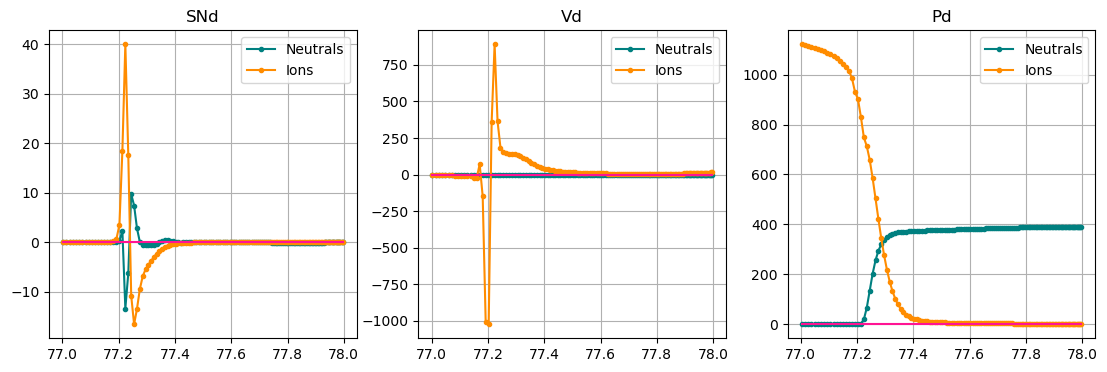

In [134]:
from matplotlib.lines import Line2D

ms = 0
lw = 2

ds = cs["base4"].ds.isel(t=-1, pos = slice(2,-2))
# ds = ds.sel(pos=slice(77.6, 78))
ds = ds.sel(pos=slice(77, 78))
pos = ds["pos"]

# params = ["SNd+", "NVd+", "Vd+", "Pd+"]
params = ["SNd", "Vd", "Pd"]
num_plots = len(params)
fig, axes = plt.subplots(1, num_plots, dpi = 100, figsize = (4.5*num_plots,4))

colors = ["teal", "darkorange"]
labels = ["Neutrals", "Ions"]

for i, param in enumerate(params):
    for j, char in enumerate(["", "+"]):
        axes[i].plot(pos, ds[f"{param}{char}"], c=colors[j], marker = "o", ms = 3, label = labels[j])
        
    axes[i].plot(pos, np.zeros_like(ds[param]), c = "deeppink")
    axes[i].set_title(param)
    axes[i].grid()
    axes[i].legend()
ax.set_xlabel("$S_{par}$ [m]")
# ax.set_ylabel("Ion source")

# ax.plot(pos, abs(ds["Fdd+_cx"]), marker = "o", ms = 3)

In [52]:
# fig, ax = plt.subplots(dpi = 100, figsize = (8,6))

df = pd.DataFrame()
for i in [0,1,2,4]:
    ds = cs[f"base{i}"].ds
    df.loc[i, "nu"] = ds["Ne"].isel(pos=1, t = -1).values
    df.loc[i, "avg_ncalls"] = np.mean(ds["ncalls"].values)
    df.loc[i, "max_ncalls"] = np.max(ds["ncalls"].values)
    
df

,nu,avg_ncalls,max_ncalls
0,6.464513e+19,29832.043189,1234068.0
1,3.771914e+19,13838.126246,637671.0
2,2.898461e+19,42099.577114,1634371.0
4,2.185204e+19,125065.855721,1481567.0


In [62]:
ds = cs["base0"].ds

ds2 = ds.isel(pos=slice(2,-2), t=-1)
idxmax = ds2["Rar"].argmax(dim="pos").values
dist = max(ds2["pos"]) - ds2["pos"][idxmax]

In [5]:
%matplotlib widget

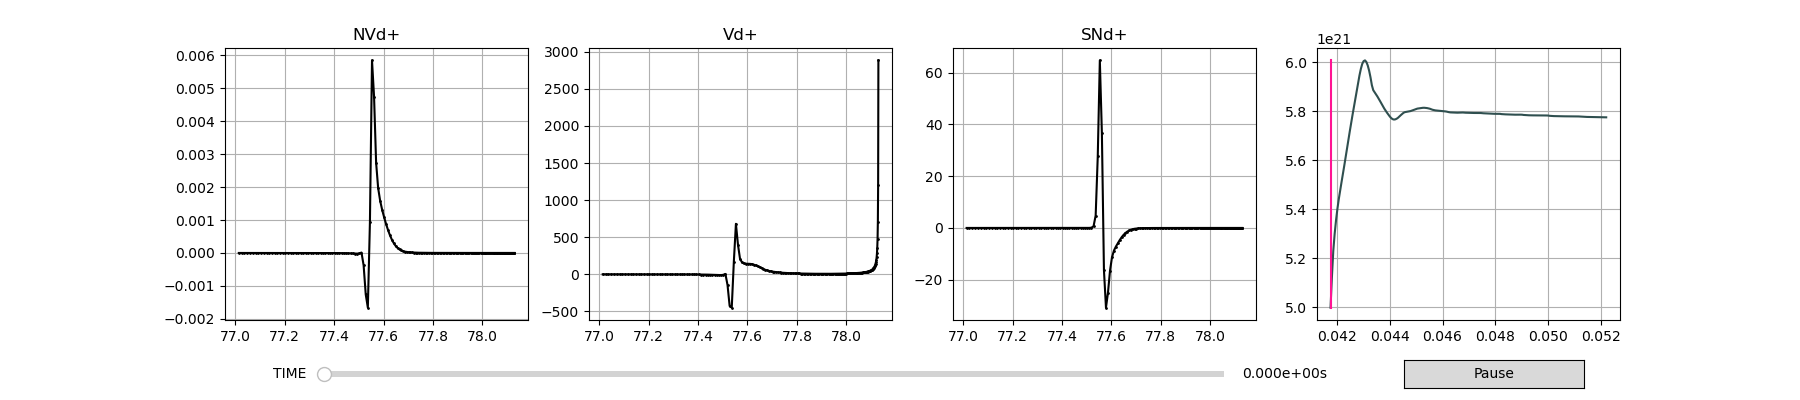

In [104]:
from hermes3.plot1d import *

animate_with_reference(cs["base4"].ds.isel(pos=slice(1,-1)).sel(pos=slice(77,None)), params = ["NVd+", "Vd+", "SNd+"], auxparam = ds["ncalls"])

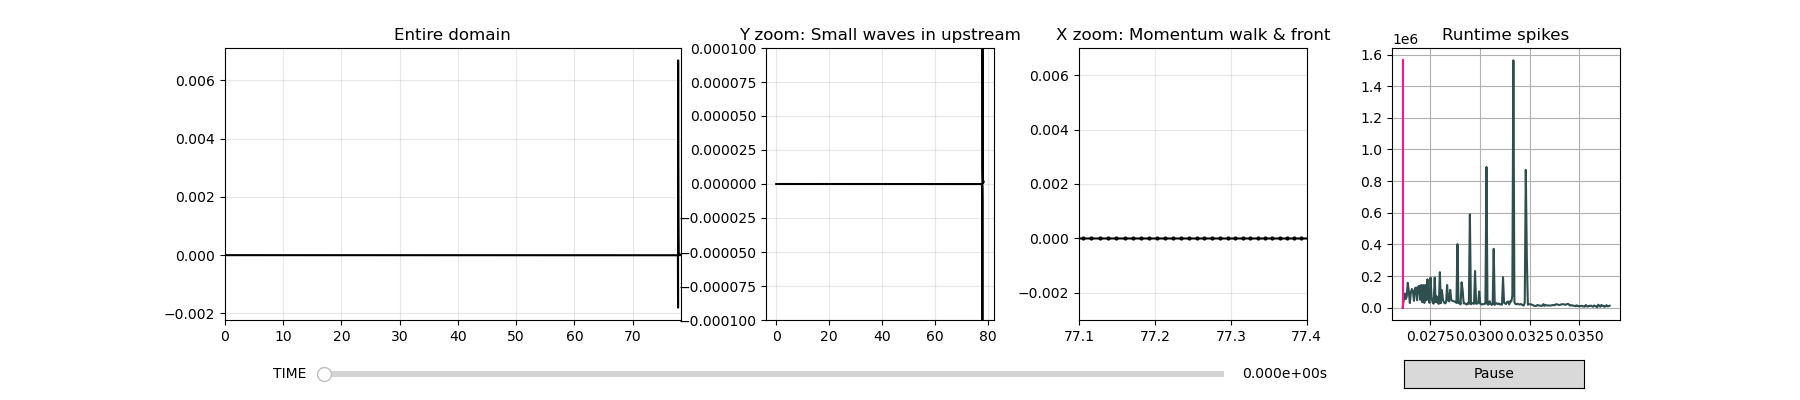

In [22]:
from matplotlib.widgets import RangeSlider, TextBox, Slider
import animatplot as amp

plt.close("all")

dpi = 100

wspace = 0.3
ds = cs["vis2"].ds.isel(pos=slice(1,-1))
# params = ["NVd+", "Sd+_iz", "Sd+_rec"]
params = ["NVd+", "NVd+", "NVd+"]
# params = ["Sd+_"]
auxparam = ds["ncalls"]
# auxparam = ((ds["Nd+"]+ds["Nd"]) * ds["dv"]).sum("pos")
t = ds.coords["t"].values
num_plots = len(params)

fig = plt.figure(dpi=dpi)
fig.set_figheight(4)
fig.set_figwidth(num_plots*6)
fig.subplots_adjust(bottom = 0.2)

# Plot grid
gs0a = mpl.gridspec.GridSpec(
                                ncols=num_plots+1, nrows=1,
                                wspace = wspace,
                                width_ratios = [0.4, 0.2, 0.2, 0.2]
                                )

axes = [None] * num_plots
data = [None] * num_plots
blocks = [None] * num_plots

timeline = amp.Timeline(t, units = "s", fps = 10)


pos = ds["pos"].values

for i, param in enumerate(params):
    data[i] = ds[param].values

# Make scanning line
vline = np.repeat(np.array([[min(auxparam.values), max(auxparam.values)]]), len(t), axis = 0)



axes[0] = fig.add_subplot(gs0a[0])
blocks[0] = amp.blocks.Line(ds["pos"], ds[param].values, ax = axes[0], color = "black", marker = "o", markersize = 0)
axes[0].set_xlim(0,78.2)
axes[0].set_title("Entire domain")
# axes[0].set_yscale("symlog")

zoomds = ds.sel(pos=slice(None,None)).copy()
axes[1] = fig.add_subplot(gs0a[1])
blocks[1] = amp.blocks.Line(zoomds["pos"], zoomds[param].values, ax = axes[1], color = "black", marker = "o", markersize = 0)
axes[1].set_ylim(-0.0001, 0.0001)
axes[1].set_title("Y zoom: Small waves in upstream")
# axes[1].set_yscale("symlog")


zoomds = ds.sel(pos=slice(76,None)).copy()
axes[2] = fig.add_subplot(gs0a[2])
blocks[2] = amp.blocks.Line(zoomds["pos"], zoomds[param].values, ax = axes[2], color = "black", marker = "o", markersize = 2)
axes[2].set_xlim(77.1, 77.4)
axes[2].set_title("X zoom: Momentum walk & front")
axes[2].set_ylim(-0.003, 0.007)

for i in [0,1,2]:
    axes[i].grid(alpha = 0.3)

# Aux plot and vline
axes.append(fig.add_subplot(gs0a[len(params)]))
axes[-1].plot(t, auxparam, c = "darkslategrey")
axes[-1].grid()
axes[-1].set_title("Runtime spikes")

# Line is two points, these are the X coordinates for those two points for all times
x = np.tile(t,  (2,1)).transpose()
blocks.append(amp.blocks.Line(x, vline, ax = axes[-1], t_axis=0, color = "deeppink"))

# blocks[-1] = 
    
anim = amp.Animation(blocks, timeline)
anim.controls({"text":"TIME", "color":"darkorange", "valfmt":"%1.3e"})
aux_plot_idx = num_plots
    
# anim.save_gif("vis4walk.gif")




In [19]:
%matplotlib widget

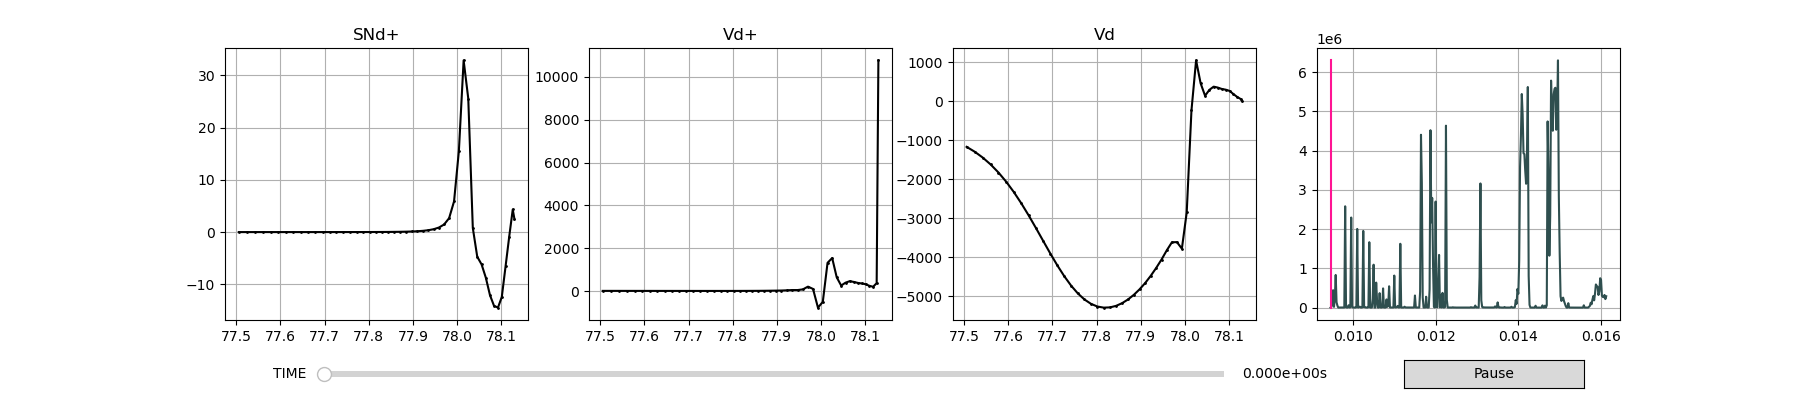

In [24]:
dpi = 100
ds = cs["8a"].ds
wspace = 0.2
params = ["SNd+", "Vd+", "Vd"]
# params = ["NVd+", "Sd+_iz", "Sd+_rec"]
# params = ["Sd+_"]
auxparam = ds["ncalls"]
# auxparam = ((ds["Nd+"]+ds["Nd"]) * ds["dv"]).sum("pos")
t = ds.coords["t"].values
num_plots = len(params)



ds = ds.isel(pos=slice(2,-1))
ds = ds.sel(pos=slice(77.5,None))

fig = plt.figure(dpi=dpi)
fig.set_figheight(4)
fig.set_figwidth(num_plots*6)
fig.subplots_adjust(bottom = 0.2)

# Plot grid
gs0a = mpl.gridspec.GridSpec(
                                ncols=num_plots+1, nrows=1,
                                wspace = wspace
                                )

axes = [None] * num_plots
data = [None] * num_plots
blocks = [None] * num_plots

timeline = amp.Timeline(t, units = "s", fps = 10)


pos = ds["pos"].values

for i, param in enumerate(params):
    data[i] = ds[param].values

# Make scanning line
vline = np.repeat(np.array([[min(auxparam.values), max(auxparam.values)]]), len(t), axis = 0)


for i, param in enumerate(params):
    # All plots after the first one share x and y axes
    if i == 0:
        axes[i] = fig.add_subplot(gs0a[i])
    else:
        axes[i] = fig.add_subplot(gs0a[i], sharex=axes[0])
        
    blocks[i] = amp.blocks.Line(pos, ds[param].values, ax = axes[i], color = "black", marker = "o", markersize = 1)
    # axes[i].set_xlim(77,78.2)
    axes[i].set_title(param)
    axes[i].grid()
    

# Aux plot and vline
axes.append(fig.add_subplot(gs0a[len(params)]))
axes[-1].plot(t, auxparam, c = "darkslategrey")
axes[-1].grid()

# Line is two points, these are the X coordinates for those two points for all times
x = np.tile(t,  (2,1)).transpose()
blocks.append(amp.blocks.Line(x, vline, ax = axes[-1], t_axis=0, color = "deeppink"))

    
anim = amp.Animation(blocks, timeline)
anim.controls({"text":"TIME", "color":"darkorange", "valfmt":"%1.3e"})
aux_plot_idx = num_plots
    

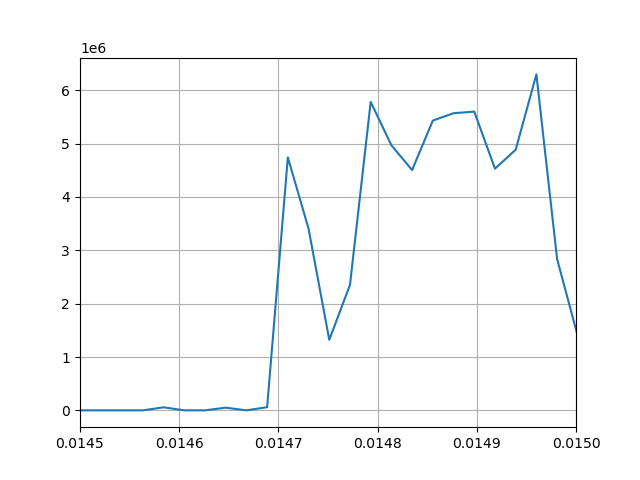

In [25]:
plt.close("all")
fig, ax = plt.subplots()
data = ds["ncalls"].values
tinds = [-15, -12, -10, -8, -6]
ax.plot(t, ds["ncalls"])
ax.vlines([t[x] for x in tinds], min(data), max(data), colors = "red")
ax.set_xlim(0.0145, 0.0150)
ax.grid()


In [276]:
%matplotlib inline

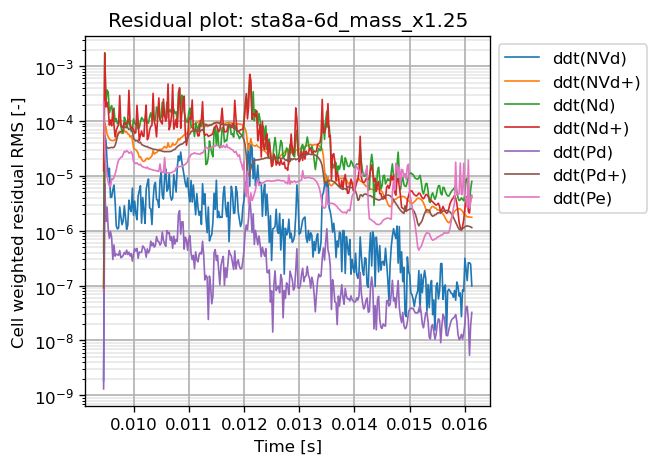

In [55]:
plot_ddt(cs["8a"])

In [280]:
%matplotlib widget

In [5]:
plt.close("all")
case = cs["base4"]
ds = case.ds.isel(pos=slice(2,-1))


def plot(list_params):
    fig, axes = plt.subplots(1, len(list_params), figsize=(len(list_params)*4.5, 4), dpi = 100)
    fig.subplots_adjust(wspace = 0.4)
    
    # times = np.arange(-30,0,2)
    # times = [-6, -5, -4, -3, -2, -1]
    # times = [-15, -12, -10, -8, -6]
    # times = [-1]
    
    times = np.linspace(5, len(ds.coords["t"])-1, 10, dtype=int)
    # alphas = np.linspace(0.1,0.8, len(times))
    alphas = [1] * len(times)
    colors = make_cmap("plasma", len(times))[::-1]
    for j, param in enumerate(list_params):
        for i, tind in enumerate(times):
            data = ds[param].isel(t=tind)
            data = data.sel(pos=slice(76.5,None))
            data.plot(ax = axes[j], x = "pos", marker = "o", label = f"tind={tind}", color = colors[i], ms = 1, lw = 2, alpha = alphas[i])
            
        axes[j].grid()
        axes[j].set_title(param)
        axes[j].legend(fontsize=8)
        # axes[j].set_yscale("symlog")
        
# plot(["Rar", "Sd+_iz", "Ne", "Td+"])
plot(["Ne", "Nd", "NVd+"])
# plot(["NVd+", "NVd"])
# plot(["NVd+", ])
plot(["Te", "Td+", "Td"])
plot(["Pe", "Pd+", "Pd"])
plot(["Sd+_iz", "Sd+_rec", "Fdd+_cx"])
plot(["Rar", "Rd+_ex"])

KeyError: 'base4'

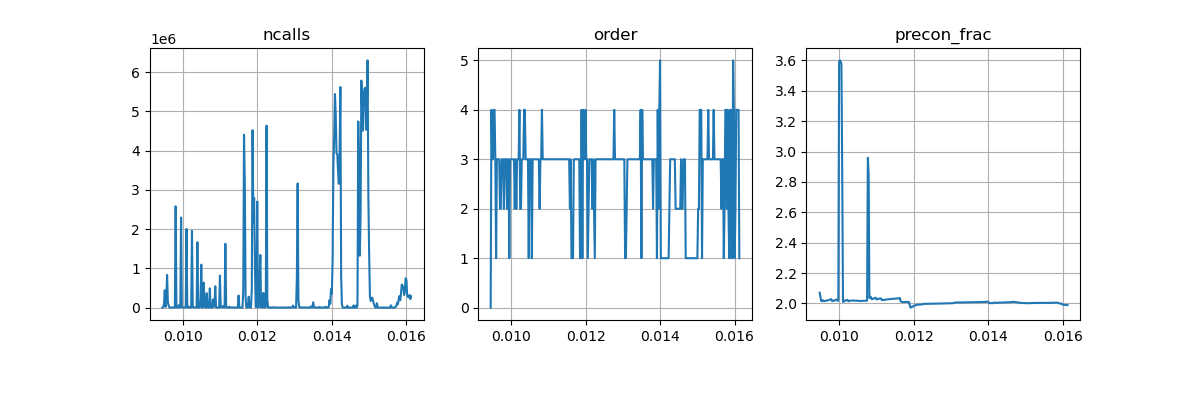

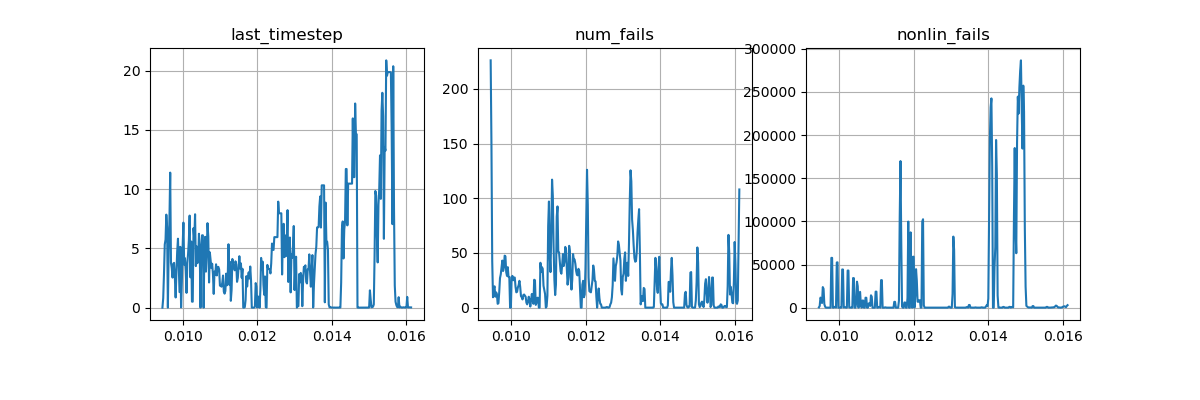

In [26]:






def plot(data):
    num_plots = len(data.keys())

    t = ds.coords["t"]

    fig = plt.figure(dpi=dpi)
    fig.set_figheight(4)
    fig.set_figwidth(num_plots*4)
    fig.subplots_adjust(bottom = 0.2)

    # Plot grid
    gs = mpl.gridspec.GridSpec(
                                    ncols=num_plots, nrows=1,
                                    wspace = wspace
                                    )



    axes = [None] * len(data.keys())


    for i, param in enumerate(data.keys()):
        # All plots after the first one share x and y axes
        if i == 0:
            axes[i] = fig.add_subplot(gs[i])
        else:
            axes[i] = fig.add_subplot(gs[i], sharex=axes[0])
            
        axes[i].plot(t, data[param])
        axes[i].set_title(param)
        axes[i].grid()
        
data = dict()
data["ncalls"] = ds["ncalls"].values
data["order"] = ds["cvode_last_order"].values
data["precon_frac"] = np.divide(ds["cvode_npevals"],(ds["cvode_nfevals"]))
# data["stab_lims"] = ds["cvode_stab_lims"]
plot(data)

data = dict()
data["last_timestep"] = ds["cvode_last_step"]
data["num_fails"] = np.clip(np.gradient(ds["cvode_num_fails"]), 0, None)
data["nonlin_fails"] = np.clip(np.gradient(ds["cvode_nonlin_fails"]), 0, None) #np.gradient(t, ds["cvode_nonlin_fails"])
plot(data)


In [32]:
cs["8a"].ds.coords

Coordinates:
    dx       (pos) float64 dask.array<chunksize=(82,), meta=np.ndarray>
    dy       (pos) float64 dask.array<chunksize=(82,), meta=np.ndarray>
    dz       (pos) float64 dask.array<chunksize=(82,), meta=np.ndarray>
  * t        (t) float64 0.009448 0.009469 0.00949 ... 0.01609 0.01611 0.01613
  * y        (y) float64 0.09392 0.2817 0.4692 0.6565 ... 78.49 78.5 78.51 78.52
  * pos      (pos) float64 -0.2814 0.0 0.09376 0.281 ... 78.12 78.13 78.13 78.14

In [45]:
%matplotlib inline

In [50]:
cs.keys()

dict_keys(['base0', 'base1', 'base2', 'base4', 'vis0', 'vis1', 'vis2', 'vis4', '8a'])

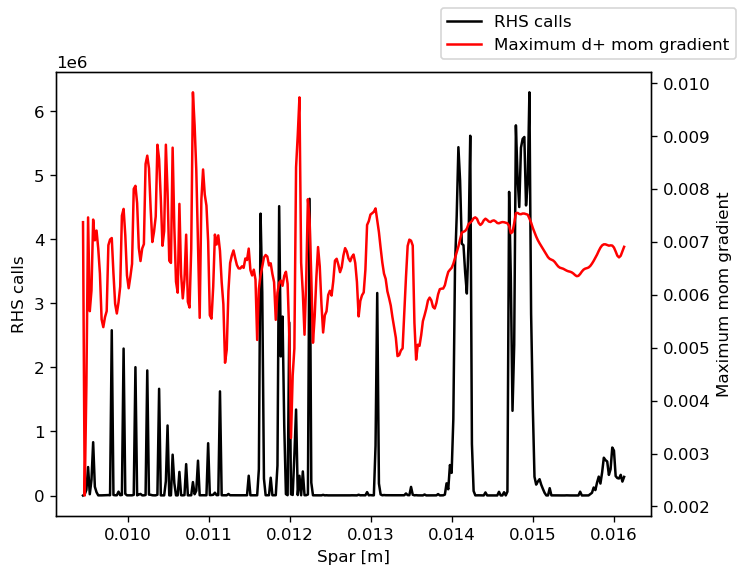

In [51]:
fig, ax = plt.subplots(dpi = 120)

ds = cs["8a"].ds
# ds = ds.isel(pos=slice(2,-1))

# pos = ds["pos"]
momgrad = ds["NVd+"].differentiate("pos")
maxgrad = momgrad.max("pos")
# momgrad = np.gradient(ds["pos"], ds["NVd+"])
# maxgrad = momgrad.max("t")
ax2 = ax.twinx()
ax.plot(ds["t"], ds["ncalls"], c = "k", label = "RHS calls")
# ax2.plot(ds["t"], maxgrad, c = "r", label = "Maximum d+ mom gradient")
ax2.plot(ds["t"], ds["NVd+"].max("pos"), c = "r", label = "Maximum d+ mom gradient")
ax.set_xlabel("Spar [m]")
ax.set_ylabel("RHS calls")
ax2.set_ylabel("Maximum mom gradient")
fig.legend()